**Generating features relating to address connectivity and activity for pudgy penguin token transactions**

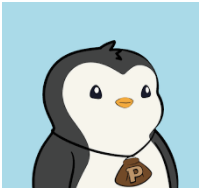

**What does this notebook contain?**

This is a proof-of-concept, showing that transactions in a specific token for a given time period can be represented as directed, weighted knowledge graph, from which features are derived for each address.

In this example, I use all transactions relating to the pudgy penguins token for the month of August 2021.

**Structure of transaction-based graphs**

The "from_address" and "to_address" fields represent the source and target nodes, respectively. The "tx_no" (number of transactions between two addresses) becomes the link weight.

In a directed graph, in-degree refers to the number of links that point inward at a node. Out-degree describes the number of links that originate at a node and point outward to other nodes.

**Graph-based features**

From a graph, centrality measures can be extracted for each node (i.e. address), for a specific time period. Doing so for successive time periods creates an index of features for each address that is active in a specific token.

**Node centrality**

For each node, I compute the eigenvector centrality, which measures the centrality of a node based on the centrality of its neighbors (i.e. address connectivity), also taking into account the connection strength between nodes (here: no of transactions, i.e. activity level).

In a directed graph, eigenvector centralities for in- and out-degrees contain information about the behavior of each address. For example, for a given address (i.e. node), the out-degree eigenvector centrality score and its evolution over time conveys information about its selling behavior. Similarly, the in-degree eigenvector centrality score conveys information about the address' purchasing behavior.

**How can these features be used?**

* Behavioral profiling. Adjust borrowing/trading terms for a specific token based on an address' score.
* Predictive modelling. Use time series of (x most central) addresses' scores for predicting changes in volatility or price levels for a specific token.



*This proof-of-concept was created on Google Colab.*

In [1]:
#Import libraries

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Authenticate user

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [97]:
#Save query output in a dataframe 'raw'

%%bigquery --project project-one-240614 raw
SELECT
  DISTINCT transactions.from_address,
  transactions.to_address,
  COUNT(*) AS tx_no,
FROM
  `bigquery-public-data.crypto_ethereum.transactions` AS transactions
JOIN
  `bigquery-public-data.crypto_ethereum.token_transfers` AS transfers
ON
  (transactions.to_address = transfers.to_address)
WHERE
  transactions.block_timestamp > '2021-08-01 00:00:00 UTC'
  AND transactions.block_timestamp <= '2021-08-31 23:59:59 UTC'
  AND transactions.from_address < transactions.to_address
  AND transfers.token_address LIKE '0xbd3531da5cf5857e7cfaa92426877b022e612cf8' #pudgy penguin token
GROUP BY
  1,
  2
ORDER BY
  3 DESC

In [146]:
print('Length of dataframe:', len(raw))

Length of dataframe: 17069


In [99]:
def build_graph(df):

  '''
  Creates directed, weighted graph from dataframe where
  from_address = source node;
  to_address = target node;
  tx_no = link weight
  '''

  G = nx.DiGraph()

  for link in df.index:
      G.add_edge(df.iloc[link]['from_address'], df.iloc[link]['to_address'], weight=df.iloc[link]['tx_no'])
  return G

In [100]:
G = build_graph(raw)

In [101]:
print('No of nodes:', len(G.nodes))
print('No of edges:', len(G.edges()))

No of nodes: 13265
No of edges: 17069


In [104]:
def plot_graph(graph, fig_path):

  '''
  Plots graph and saves figure
  '''

  pos = nx.random_layout(graph)

  nodes = graph.nodes()
  edges = graph.edges()
  fig, axs = plt.subplots(1, 1, figsize=(30,30))
  nds = nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color='mediumaquamarine', alpha=0.5, node_size=20, ax=axs) #mediumaquamarine
  edgs = nx.draw_networkx_edges(graph, pos, edgelist=edges, width=0.2, alpha=0.5, edge_color='grey')

  fig.savefig(fig_path)


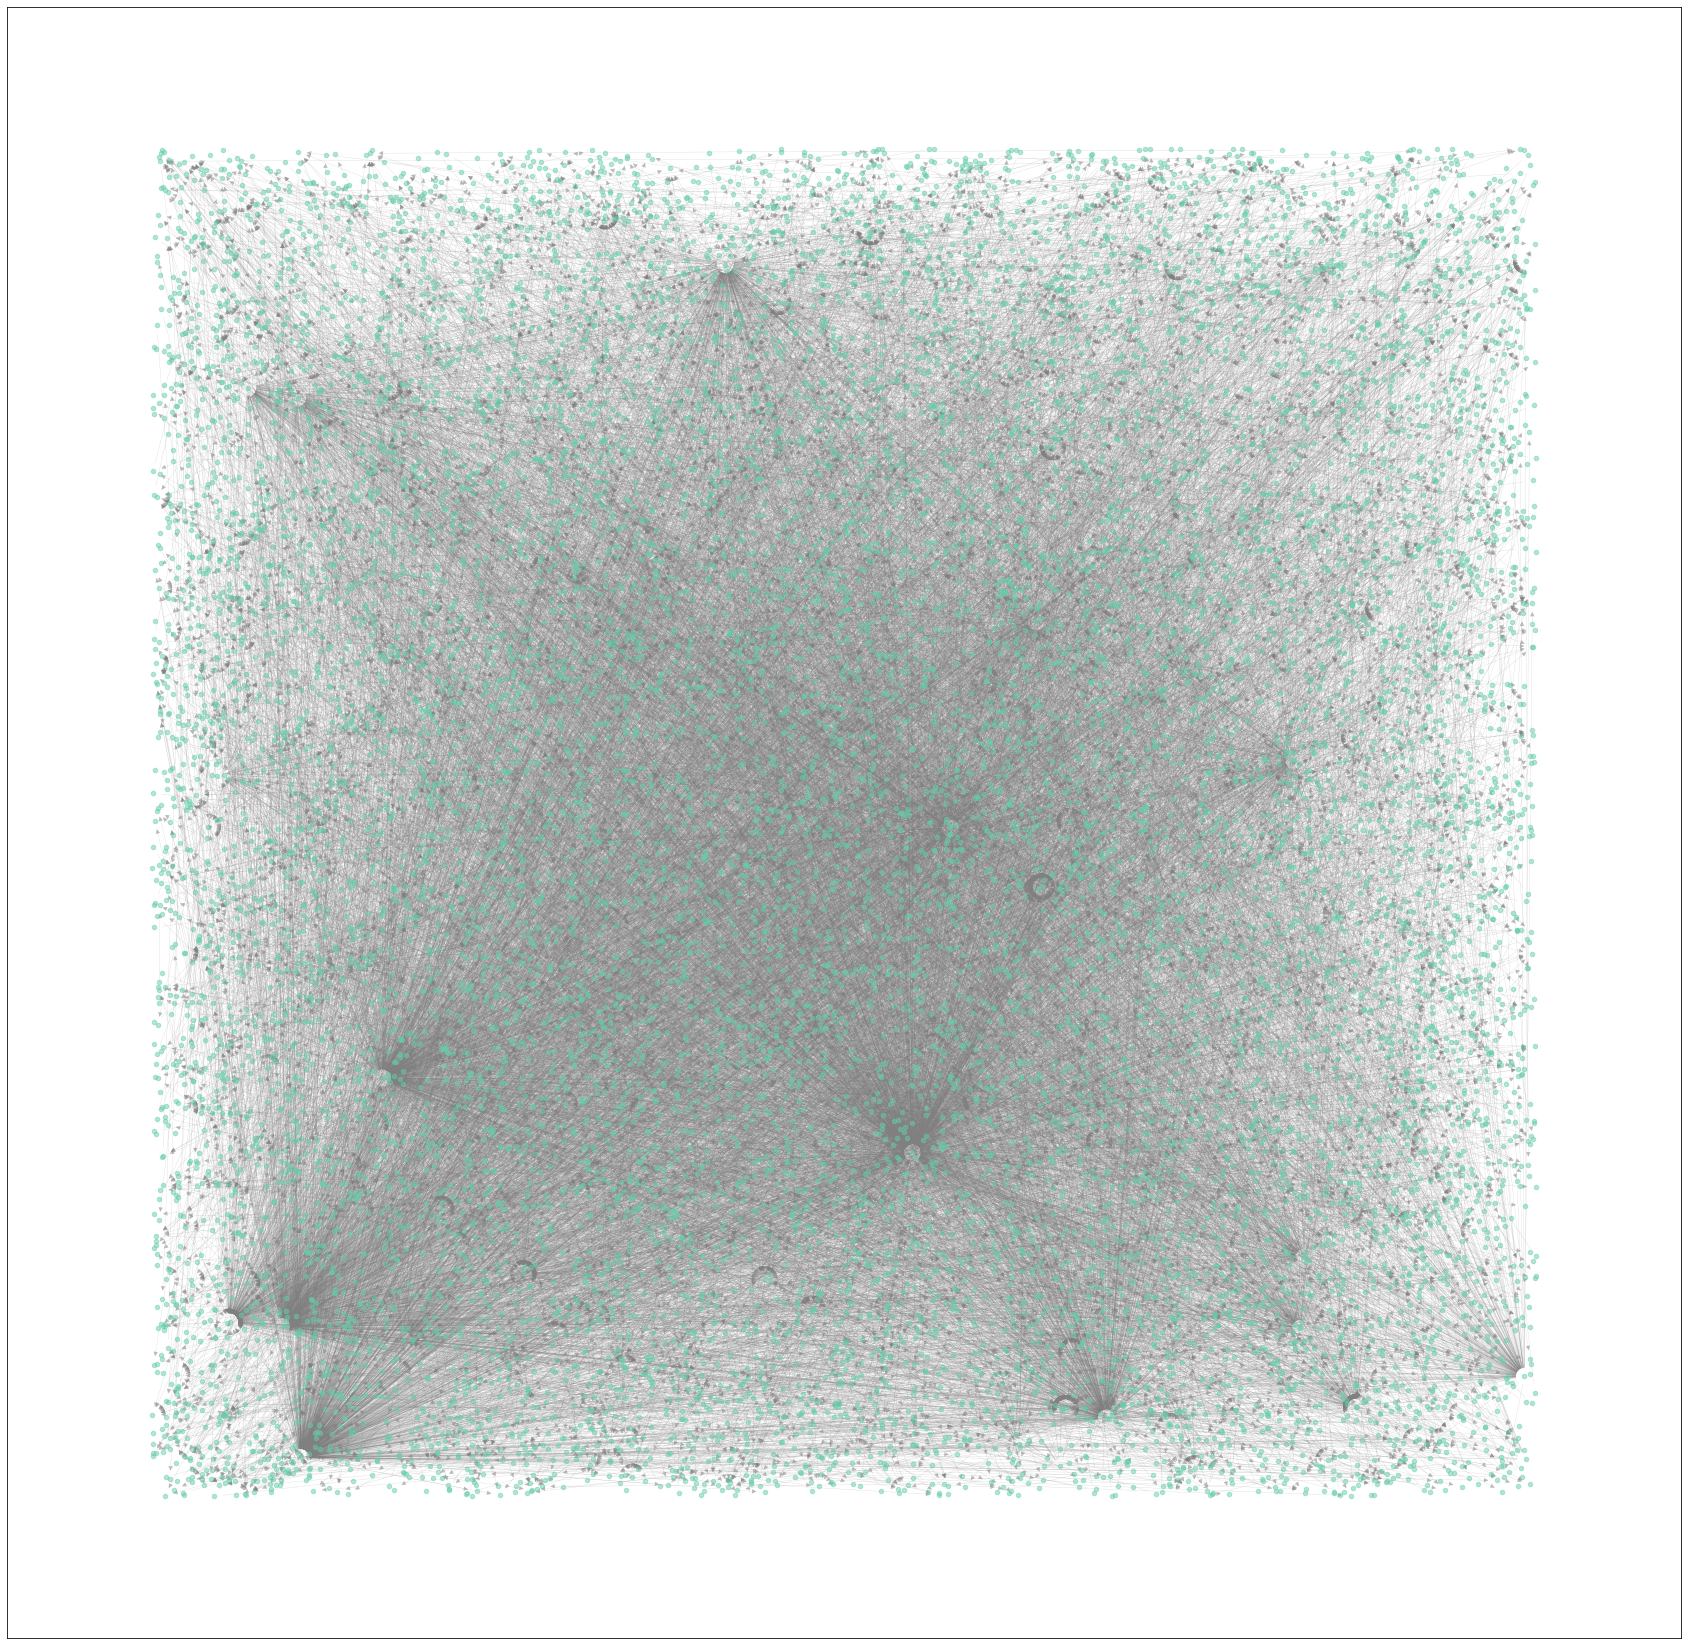

In [105]:
plot_graph(G, r'/content/drive/My Drive/ARCX/tx_pudgy_pengs_0821.jpg')

The visualisation of the transaction network for pudgy penguin tokens for August 2021 shows that there are few very central addresses (those with either many in- or out-degrees. 

In [152]:
def create_ec(graph, file_path):

  '''
  Calculates each the eigenvector centrality for each node (i.e. address)
  for a weighted graph
  '''
  ec = nx.eigenvector_centrality(graph, weight='weight')
  ec = pd.DataFrame(ec.items(), columns=['address', 'ec'])
  ec_sorted = ec.sort_values('ec', ascending=False).set_index('address').transpose()
  ec_sorted.to_csv(file_path)
  return ec_sorted

In [153]:
#Generate and save eigenvector centralities from an in-degree perspective

ec_in_feats = create_ec(G, r'/content/drive/My Drive/ARCX/ec_in_pudgy_pengs_0821.csv')

In [155]:
#Generate and save eigenvector centralities from an out-degree perspective

ec_out_feats = create_ec(G.reverse(), r'/content/drive/My Drive/ARCX/ec_out_pudgy_pengs_0821.csv')

The distribution of eigenvector centralities - both for in- and out-degrees - follows the power-law, with very few large values and a long tail of small values.

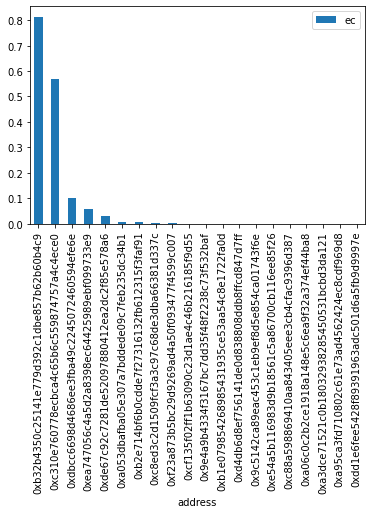

In [176]:
ec_in_feats.T[:20].plot(kind='bar')
plt.show()

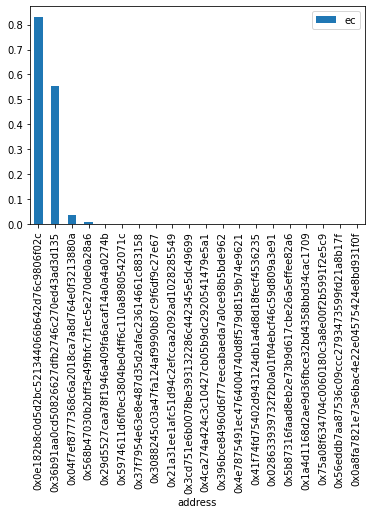

In [177]:
ec_out_feats.T[:20].plot(kind='bar')
plt.show()

**Closing thought: graph similarity as further feature**

It would be interesting to track the evolution of the graph structure over time. This can be done by computing the jaccard coefficient between the current and the prior period's graph. Such a graph similarity measure may be useful for predicting volatility in a specific token, which may be associated with structural shifts in a graph's topology.

I have not implemented this here as the pudgy penguin token has not been around for long and thus lacks a track record.

In [ ]:
def jaccard_similarity(g, h):

    '''
    Computes the jaccard similarity score
    between two graphs. This can be either
    based on graph nodes or graph links.
    '''

    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 4)